In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.distributions as dist
import pyro
import pyro.distributions as pyro_dist
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO
# from pyro.nn import PyroSample, PyroModule

import bayesreg_pyro as br

In [3]:
data = pd.read_csv("bodyfat.csv").drop("Density", axis=1)
data = data - data.mean()

In [27]:
# sns.pairplot(data)
# plt.show()

In [4]:
# prepare data
y_data = torch.Tensor(data["Bodyfat"].values)
x_data = torch.Tensor(data.drop("Bodyfat", axis=1).values)
in_features = x_data.shape[1]

In [15]:
model = br.BayesianRegression(in_features, 1)
guide = AutoDiagonalNormal(model) # Stochastic Mean field
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())


In [16]:
pyro.clear_param_store()
elbos, samples = br.run_vi(x_data, y_data, svi, model, guide)

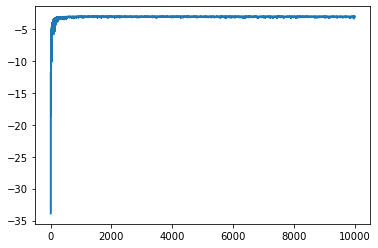

In [35]:
plt.plot(elbos[10:])

In [56]:
guide.requires_grad_(False)
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

linear.bias Parameter containing:
tensor([-2.0671e-08], requires_grad=True)
AutoDiagonalNormal.loc Parameter containing:
tensor([ 1.4624,  0.0654, -0.1008, -0.0705, -0.4885, -0.0277,  0.9421, -0.2089,
         0.2299,  0.0142,  0.1545,  0.1738,  0.4388, -1.2176])
AutoDiagonalNormal.scale tensor([0.0457, 0.0220, 0.0101, 0.0663, 0.1282, 0.0245, 0.0266, 0.0396, 0.0496,
        0.0965, 0.1277, 0.0885, 0.1204, 0.3208])


In [20]:
# VI results
np.round(pd.DataFrame(
    {
        "loc": pyro.param("AutoDiagonalNormal.loc").numpy().reshape(-1, ),
        "scale": pyro.param("AutoDiagonalNormal.scale").numpy().reshape(-1, ),
    }, index=["Intercept"] + list(data.drop("Bodyfat", axis=1).columns)), 2)

,loc,scale
Intercept,1.45,0.04
Age,0.04,0.02
Weight,-0.08,0.01
Height,-0.05,0.06
Neck,-0.49,0.12
Chest,-0.01,0.03
Abdomen,0.97,0.03
Hip,-0.18,0.04
Thigh,0.25,0.05
Knee,0.02,0.08


In [22]:
hmc_samples = br.run_hmc(x_data, y_data, model)

Sample: 100%|██████████| 1200/1200 [01:18, 15.28it/s, step size=1.30e-01, acc. prob=0.939]


In [34]:
# HMC results
# I don't know where the intercept is..
np.round(pd.DataFrame(
    {
        "loc": hmc_samples["linear.weight"].mean(axis=0),
        "scale": hmc_samples["linear.weight"].std(axis=0),
    }, index= list(data.drop("Bodyfat", axis=1).columns)), 2)


,loc,scale
Age,0.06,0.03
Weight,-0.10,0.05
Height,-0.07,0.10
Neck,-0.48,0.22
Chest,-0.02,0.10
Abdomen,0.95,0.09
Hip,-0.19,0.15
Thigh,0.24,0.15
Knee,0.02,0.24
Ankle,0.13,0.22
